In [1]:
# Load necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
df = pd.read_csv('/workspaces/4Geeks-flask-render-self/data/cleaned_df.csv')


In [3]:
# Select relevant columns for analysis
df = df[['State', 'Bedroom', 'Bathroom', 'Area', 'PPSq', 'LotArea', 'MarketEstimate', 'RentEstimate', 'ListedPrice']]

In [4]:
# EDA - Basic statistics and missing values
print(df.describe())
print(df.isnull().sum())

            Bedroom      Bathroom          Area          PPSq       LotArea  \
count  22667.000000  22647.000000  22681.000000  22681.000000  21779.000000   
mean       3.393435      2.423299   2128.138398    222.641994      2.354870   
std        1.050506      1.157670   1577.512556    202.811788     16.128371   
min        0.000000      0.000000    120.000000      1.925926      0.000000   
25%        3.000000      2.000000   1400.000000    132.729544      0.173439   
50%        3.000000      2.000000   1849.000000    184.122149      0.299449   
75%        4.000000      3.000000   2466.000000    257.118205      0.930000   
max       21.000000     25.000000  99990.000000   6117.071334    800.000000   

       MarketEstimate   RentEstimate   ListedPrice  
count    1.544500e+04   16705.000000  2.268100e+04  
mean     4.870383e+05    2624.699192  5.324399e+05  
std      1.155986e+06    4029.614920  1.574922e+06  
min      1.570000e+04     100.000000  4.888000e+03  
25%      2.306000e+05  

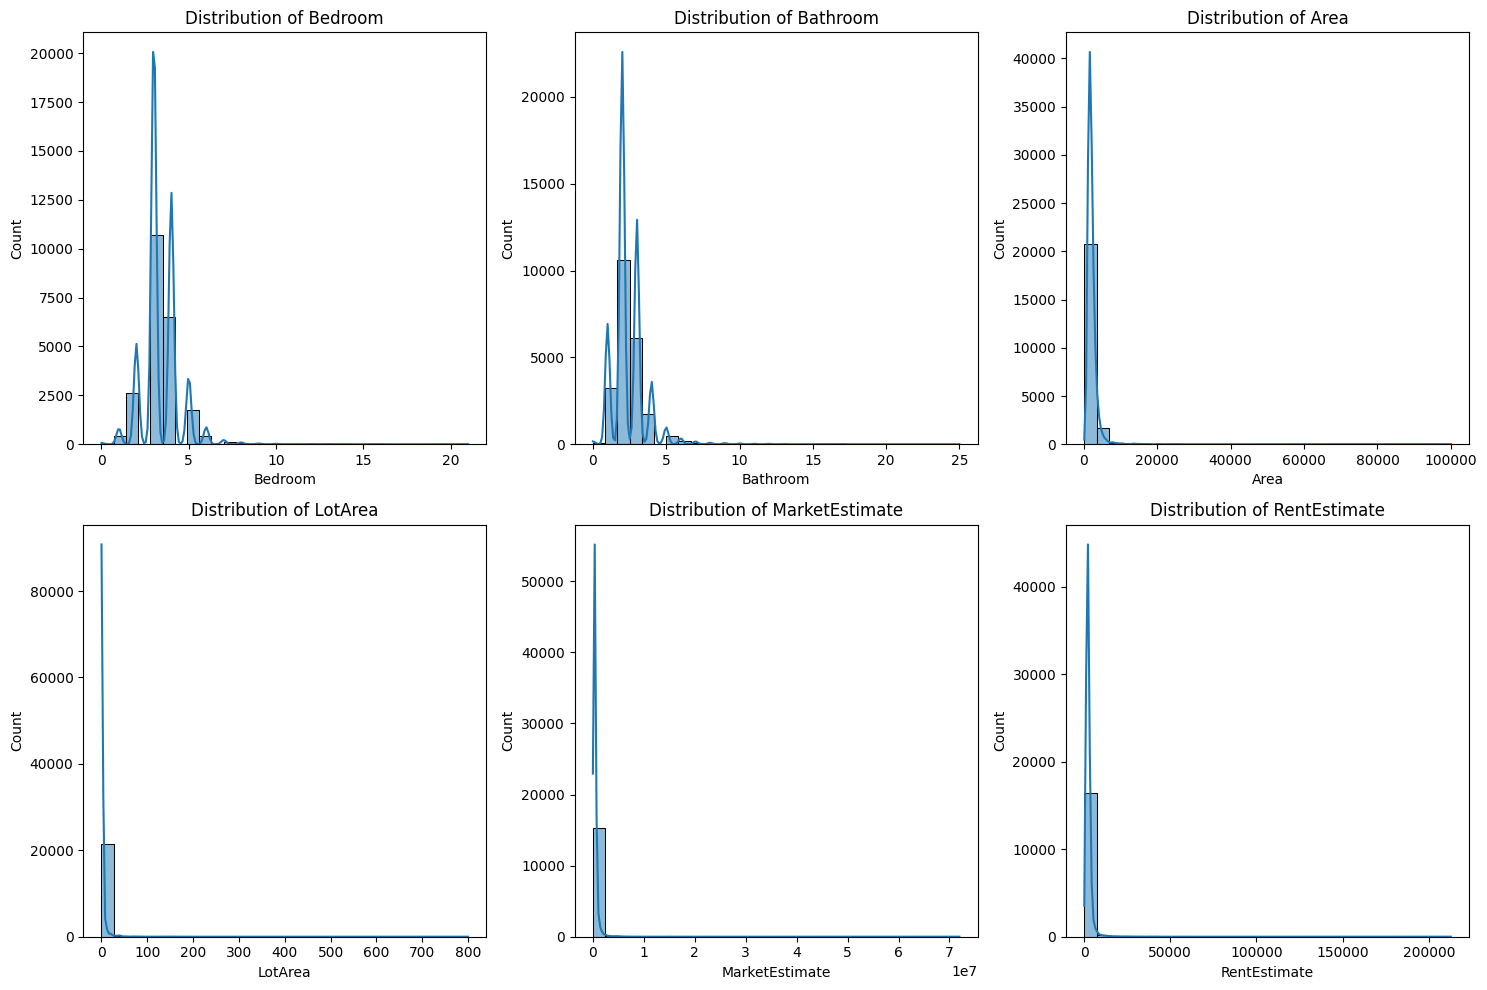

In [5]:
# 1. Distribution of numerical features
plt.figure(figsize=(15, 10))
for i, column in enumerate(['Bedroom', 'Bathroom', 'Area', 'LotArea', 'MarketEstimate', 'RentEstimate']):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

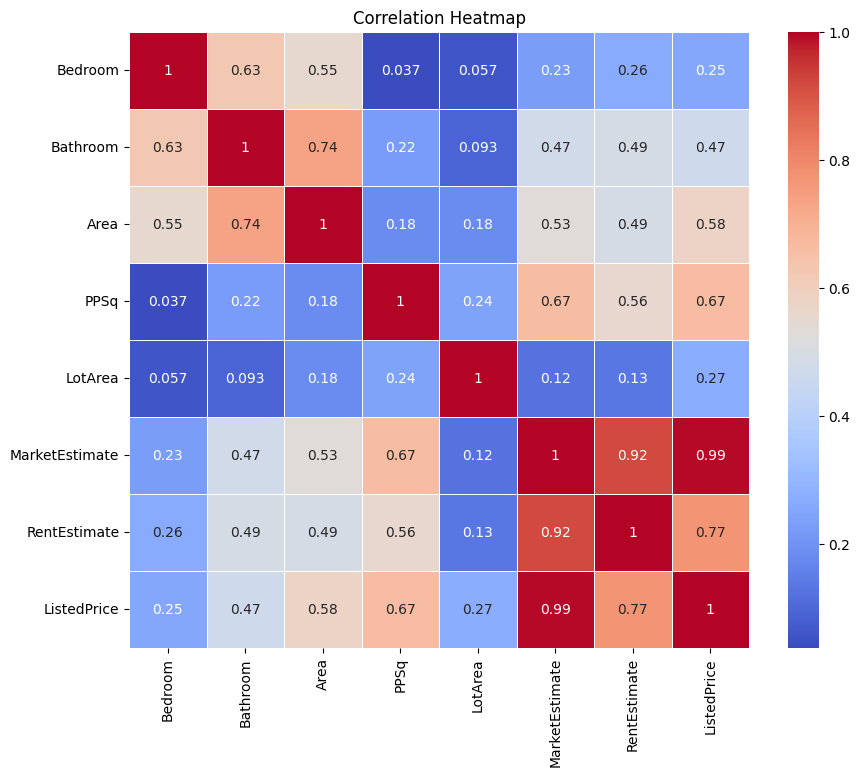

In [6]:
# 2. Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

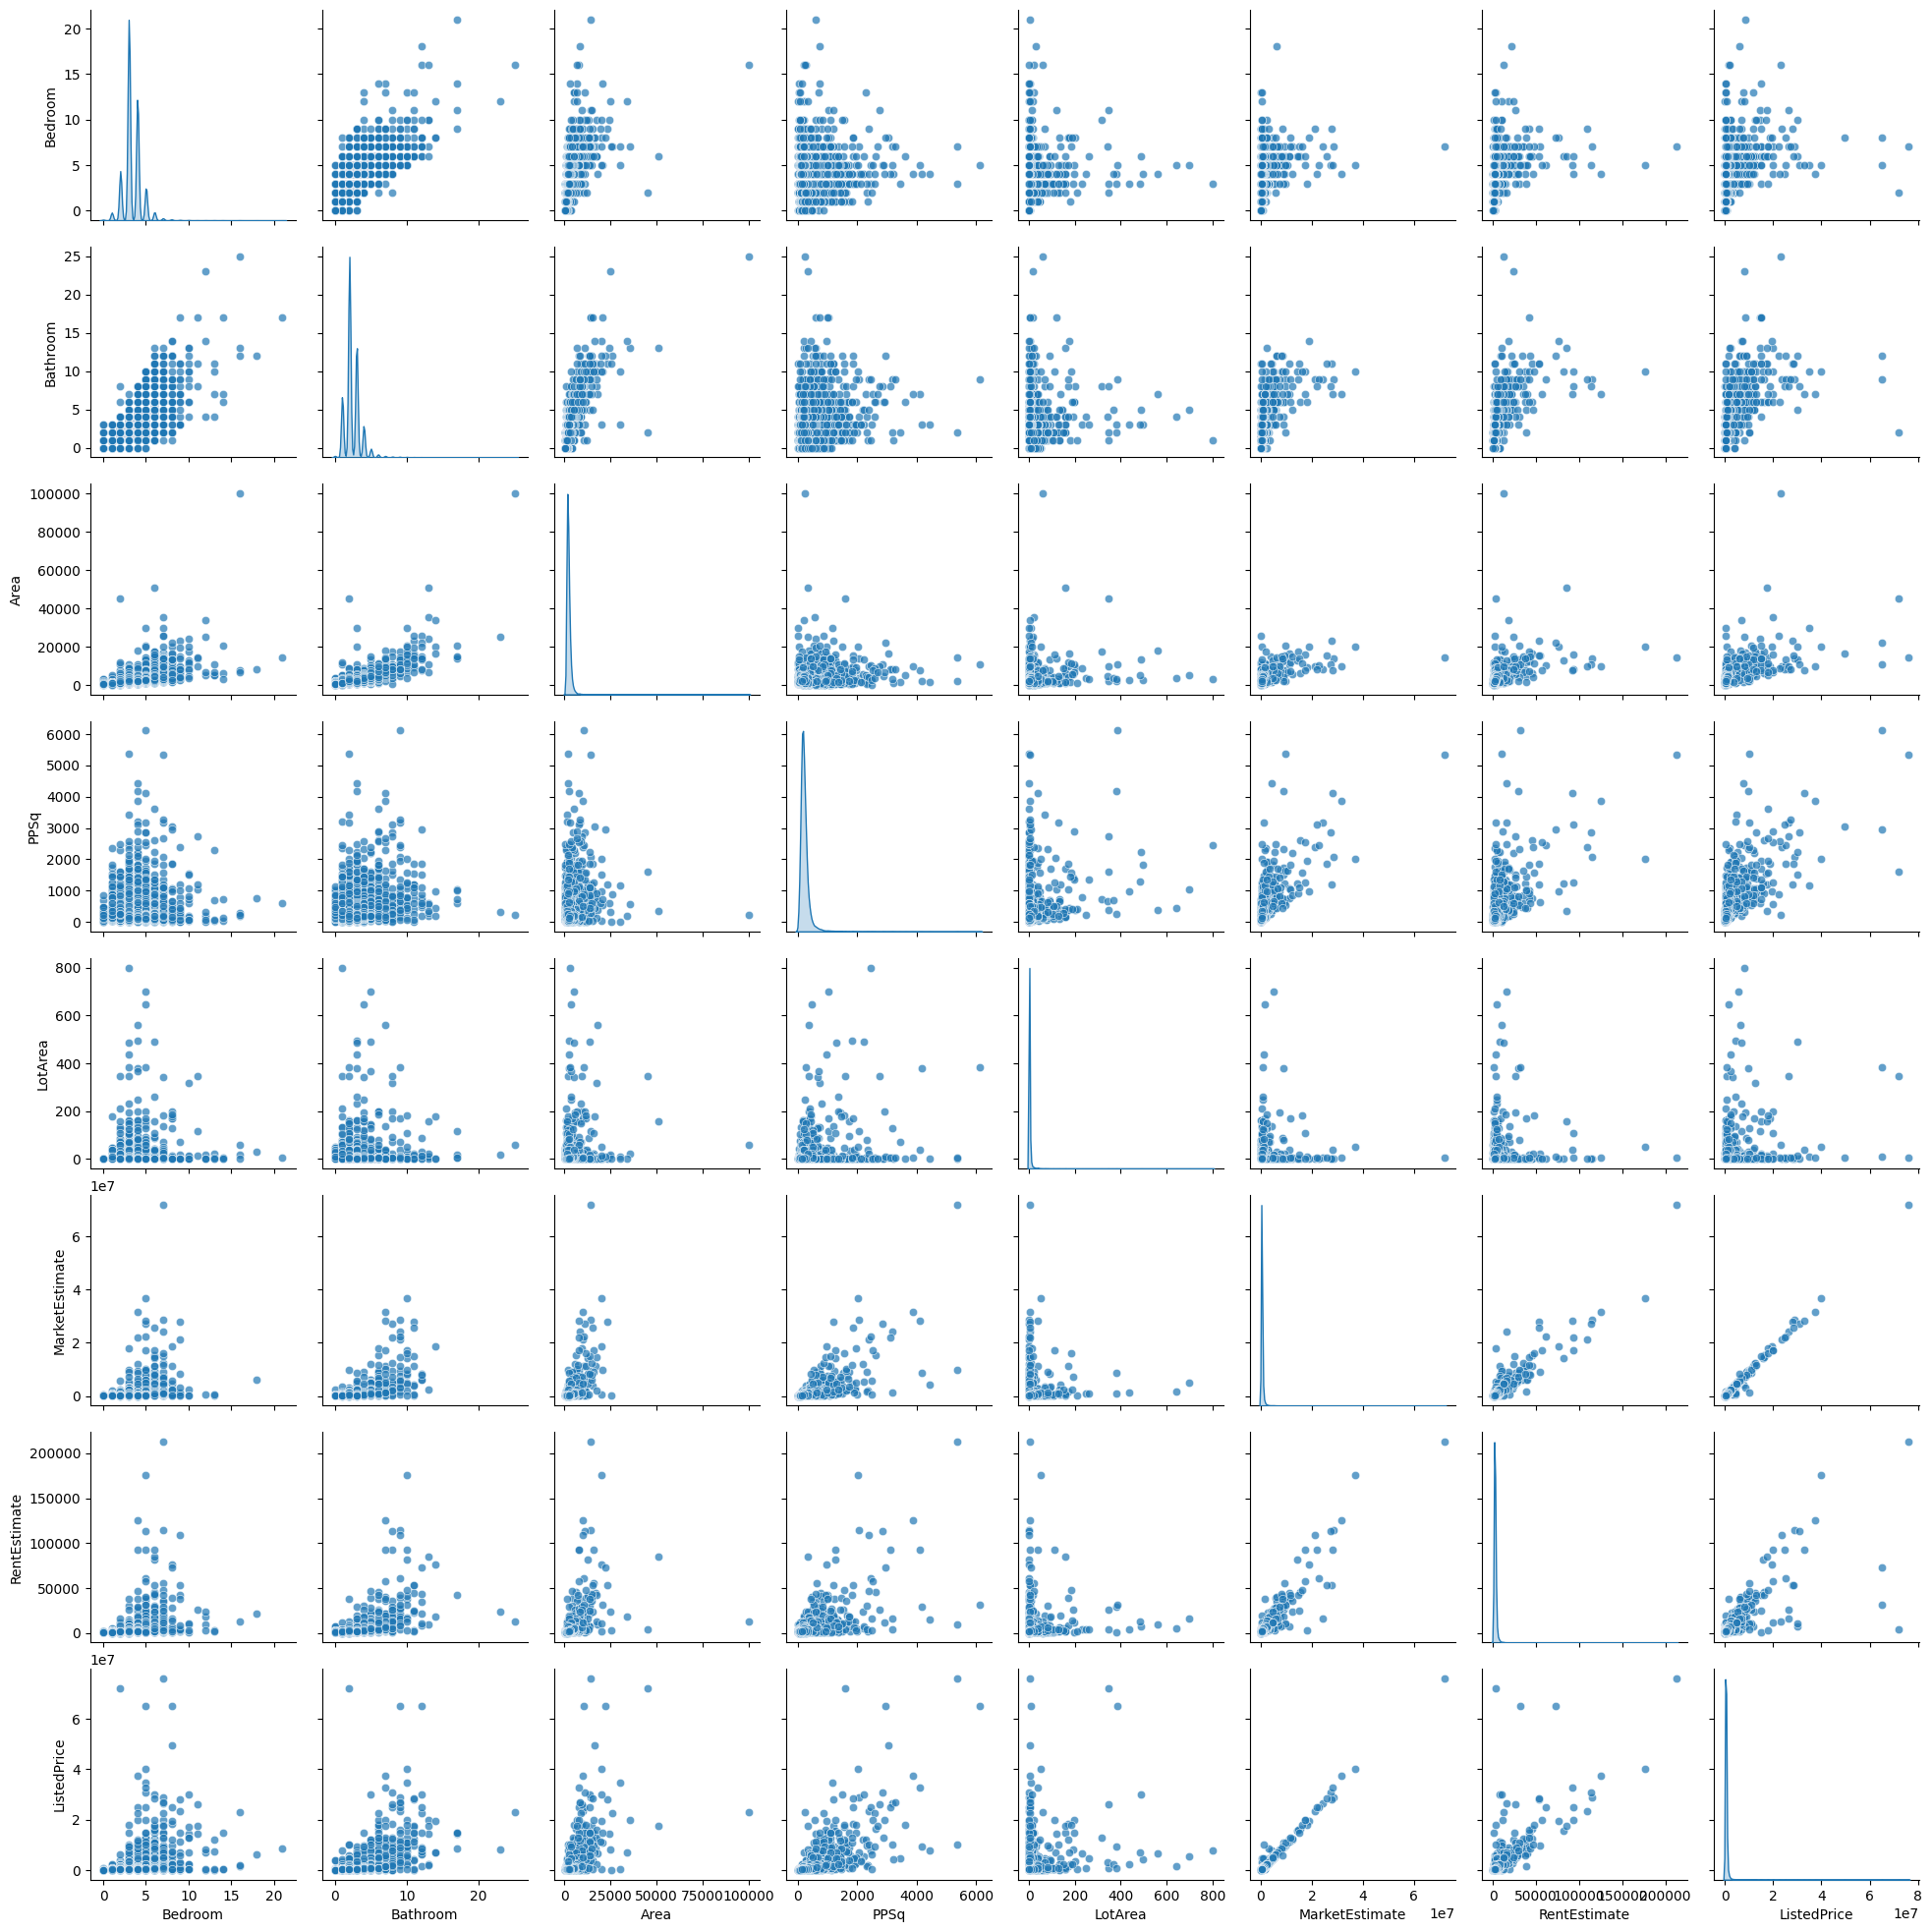

In [7]:
# 3. Pairplot to explore relationships between numerical features
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.7})
plt.show()

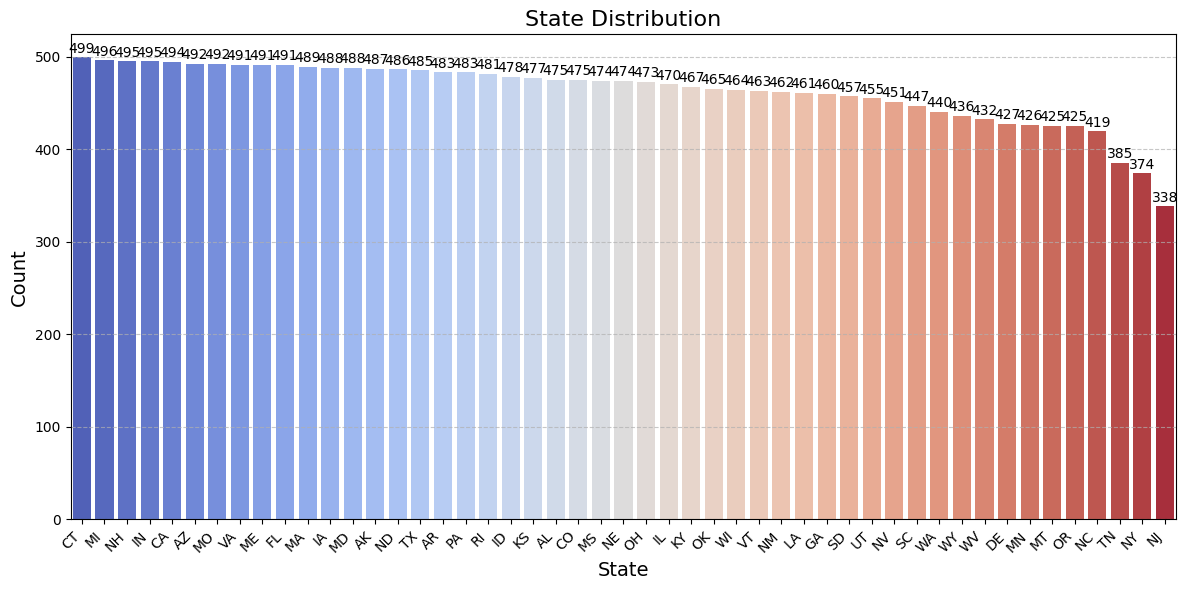

In [8]:
# 4. Categorical: Countplot of State
# Set the plot size
plt.figure(figsize=(12, 6))

# Sort states by count
sorted_state_counts = df['State'].value_counts().index

# Create the countplot
sns.countplot(data=df, x='State', order=sorted_state_counts, palette='coolwarm')

# Add title and labels
plt.title('State Distribution', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add count labels on top of the bars
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height() + 5, 
             int(p.get_height()), ha='center')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

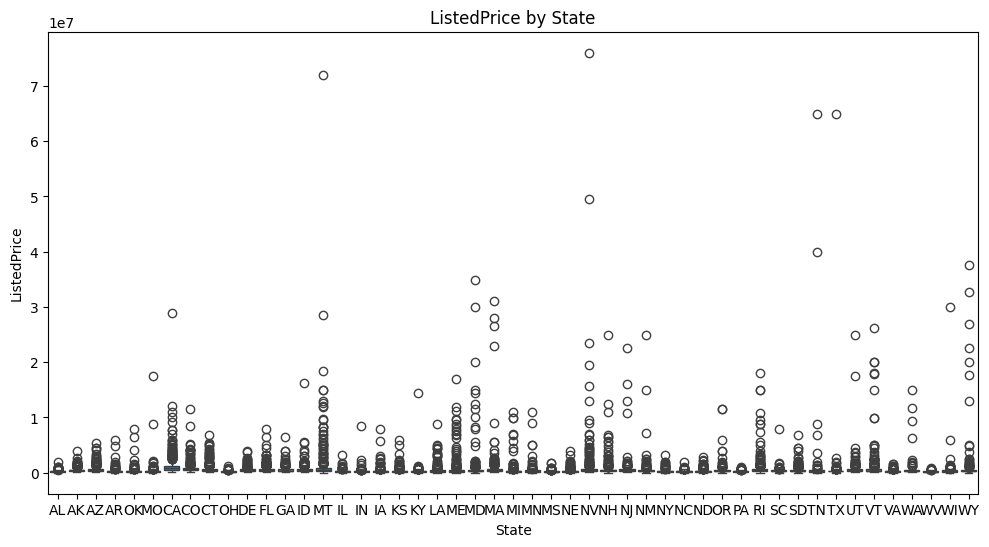

In [9]:
# 5. Boxplot: State vs ListedPrice
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='State', y='ListedPrice')
plt.title('ListedPrice by State')
plt.show()

Feature Engineering

In [10]:
# Handle 0 Bathrooms: Drop or Replace
df = df[df['Bathroom'] != 0]  # Drop rows with 0 Bathrooms

In [11]:
# Create 'Bedroom_to_Bathroom' ratio, handling 0 bedrooms
df['Bedroom_to_Bathroom'] = np.where(df['Bedroom'] == 0, 0, df['Bedroom'] / df['Bathroom'])

In [12]:
# Create 'Area_per_Bedroom' and set to NaN for 0 bedrooms (to be imputed later)
df['Area_per_Bedroom'] = np.where(df['Bedroom'] == 0, np.nan, df['Area'] / df['Bedroom'])

In [13]:
# Preprocessing: OneHotEncode the 'State' column, scale numerical features, and handle missing values
categorical_cols = ['State']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
            ('scaler', StandardScaler())
        ]), ['Bedroom', 'Bathroom', 'Area', 'LotArea', 'MarketEstimate', 'RentEstimate', 'PPSq', 'Bedroom_to_Bathroom', 'Area_per_Bedroom']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [14]:
# Features and target
X = df[['State', 'Bedroom', 'Bathroom', 'Area', 'LotArea', 'MarketEstimate', 'RentEstimate', 'PPSq', 'Bedroom_to_Bathroom', 'Area_per_Bedroom']]
y = df['ListedPrice']

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Models to be tuned
models = {
    'KNeighborsRegressor': KNeighborsRegressor(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor()
}

In [17]:
# Hyperparameter grids
param_grids = {
    'KNeighborsRegressor': {
        'kneighborsregressor__n_neighbors': [3, 5, 7, 9, 11],
        'kneighborsregressor__weights': ['uniform', 'distance']
    },
    'SVR': {
        'svr__C': [0.1, 1, 10, 100],
        'svr__kernel': ['linear', 'rbf', 'poly'],
        'svr__gamma': ['scale', 'auto']
    },
    'RandomForestRegressor': {
        'randomforestregressor__n_estimators': [50, 100, 200],
        'randomforestregressor__max_depth': [10, 20, 30, None],
        'randomforestregressor__min_samples_split': [2, 5, 10]
    },
    'GradientBoostingRegressor': {
        'gradientboostingregressor__n_estimators': [50, 100, 200],
        'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
        'gradientboostingregressor__max_depth': [3, 5, 7]
    }
}

In [18]:
# Function to save model using pickle with .sav file format
def save_model(model, model_name, save_path='/workspaces/4Geeks-flask-render-self/models'):
    # Ensure the directory exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Save the model using pickle as .sav
    model_filename = f"{model_name}_best_model.sav"
    model_path = os.path.join(save_path, model_filename)
    
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model saved at {model_path}")

In [19]:
# Model Tuning with Cross-Validation and saving
def tune_model(model_name, model, param_grid):
    pipe = Pipeline(steps=[('preprocessor', preprocessor), (model_name.lower(), model)])
    
    # Perform hyperparameter tuning using RandomizedSearchCV
    search = RandomizedSearchCV(pipe, param_grid, n_iter=10, cv=5, scoring='neg_root_mean_squared_error', random_state=42)
    search.fit(X_train, y_train)
    
    # Print the best parameters and cross-validated RMSE score
    print(f"Best params for {model_name}: {search.best_params_}")
    print(f"Best cross-validated RMSE: {-search.best_score_:.2f}")
    
    # Evaluate the tuned model on the test set
    y_pred = search.best_estimator_.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Test RMSE for {model_name}: {test_rmse:.2f}")
    print()
    
    # Save the best model using the updated save_model function
    save_model(search.best_estimator_, model_name)

In [20]:
# Tuning and saving models for each model in the list
for model_name, model in models.items():
    tune_model(model_name, model, param_grids[model_name])

Best params for KNeighborsRegressor: {'kneighborsregressor__weights': 'distance', 'kneighborsregressor__n_neighbors': 5}
Best cross-validated RMSE: 781644.93
Test RMSE for KNeighborsRegressor: 383507.59

Model saved at /workspaces/4Geeks-flask-render-self/models/KNeighborsRegressor_best_model.sav
Best params for SVR: {'svr__kernel': 'linear', 'svr__gamma': 'scale', 'svr__C': 100}
Best cross-validated RMSE: 1156522.00
Test RMSE for SVR: 877231.89

Model saved at /workspaces/4Geeks-flask-render-self/models/SVR_best_model.sav
Best params for RandomForestRegressor: {'randomforestregressor__n_estimators': 100, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__max_depth': 20}
Best cross-validated RMSE: 487337.58
Test RMSE for RandomForestRegressor: 246425.89

Model saved at /workspaces/4Geeks-flask-render-self/models/RandomForestRegressor_best_model.sav
Best params for GradientBoostingRegressor: {'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor_